В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


In [ ]:
!pip install wandb
import wandb
!wandb login

In [2]:
from google.colab import drive
import sys
drive.mount('/content/gdrive', force_remount=True)

sys.path.append('gdrive/MyDrive/HSE/GenModels/GAN')

Mounted at /content/gdrive


In [ ]:
!unzip 'gdrive/MyDrive/HSE/GenModels/VAE/celeba.zip' 

In [56]:
import numpy as np
import torchvision

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import copy

from tqdm.notebook import tqdm
from IPython.display import clear_output


import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
seed = 23
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'

# Data

In [6]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
params = {'batch_size': 16}

In [8]:
celeba = torchvision.datasets.CelebA('celeba', split='all', target_type='attr', transform=transforms, download=True)

test_size = 2000
train_size = len(celeba) - test_size
trainset, testset = random_split(celeba, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(trainset, params['batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, params['batch_size'], shuffle=False)

print(len(trainset), len(testset))

Files already downloaded and verified
200599 2000


In [82]:
index2attr = {i:j for i, j in enumerate(celeba.attr_names)}
attr = [4, 8, 9, 11, 17, 20, 24, 26, 31, 35, 39]
# attr = [8, 20, 24, 31]
test_attr = [1, 2, 5, 8, 10]
# test_attr = [20, 31]
for a in attr:
    print(a, index2attr[a])

4 Bald
8 Black_Hair
9 Blond_Hair
11 Brown_Hair
17 Gray_Hair
20 Male
24 No_Beard
26 Pale_Skin
31 Smiling
35 Wearing_Hat
39 Young


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

In [10]:
sys.path.append('gdrive/MyDrive/HSE/GenModels/GAN')

In [14]:
from model import StarGAN
from utils import permute_labels
from calculate_fid import calculate_fid


params.update({
    'n_dim': len(attr), # 11
    'n_res': 6,
    'img_size': 64,
    'n_hidden': 3,
    'g_lr': 1e-4,
    'd_lr': 1e-4,
    'b1': 0.5,
    'b2': 0.999,
    'lambda_gp': 10,
    'lambda_clf': 1,
    'lambda_rec': 10,
    'epochs': 50, 
    'n_critic': 5,
    'n_fid': 5,
    'decay_start': 10
})


model = StarGAN(params)
model.to(device)
model.load('gdrive/MyDrive/HSE/GenModels/GAN/weights/stargan_new2.pth')

In [12]:
run = wandb.init(project='GAN', name='StarGAN', config=params)
model.load('gdrive/MyDrive/HSE/GenModels/GAN/weights/stargan_new.pth')
i = 0
decay_epochs = params['epochs'] - params['decay_start']
d_adv_loss, d_clf_loss, d_loss = [], [], []
g_adv_loss, g_clf_loss, g_rec_loss, g_loss = [], [], [], []
for epoch in tqdm(range(24, params['epochs']), desc='Epochs'):
    model.train()
    for image, label in tqdm(train_dataloader, desc='trainloop'):
        image = image.to(device)
        label = label.to(device)
        label_src = label[:, attr].float()
        
        label_trg = permute_labels(label_src)
        d_adv, d_clf, d = model.trainD(image, label_src, label_trg)
        d_adv_loss.append(d_adv)
        d_clf_loss.append(d_clf)
        d_loss.append(d)
        
        
        if i % params['n_critic'] == 0:
            g_adv, g_clf, g_rec, g = model.trainG(image, label_src, label_trg)
            g_adv_loss.append(g_adv)
            g_clf_loss.append(g_clf)
            g_rec_loss.append(g_rec)
            g_loss.append(g)
            
        if epoch > params['decay_start']:
            coef = 1.0 - (epoch - params['decay_start']) / decay_epochs
            d_lr = params['d_lr'] * coef
            g_lr = params['g_lr'] * coef
            model.update_lr(g_lr, d_lr)

        if i % 500 == 0:
            model.save('gdrive/MyDrive/HSE/GenModels/GAN/weights/stargan_new2.pth')
            model.eval()
            fid = calculate_fid(test_dataloader, model, attr)
            images, labels = next(iter(test_dataloader))
            images, labels = images[:5].to(device), labels[:5].to(device)
            labels  = labels[:, attr]
            log_img = []
            for image, label_src in zip(images, labels):
                eye = torch.eye(label_src.shape[0]).to(device)
                label_trg = torch.abs(label_src - eye)
                # label_trg = label_trg[test_attr, :].float()
                image = image.unsqueeze(0).repeat(len(attr), 1, 1, 1)
                fake_image = model.generate(image.squeeze().to(device), label_trg.squeeze().to(device)).detach()
                combine = torch.cat([torch.cat([real.unsqueeze(0), fake.unsqueeze(0)]) for real, fake in zip(image, fake_image)])
                log_img.append(combine)

            log_img = torch.cat(log_img, dim=0).cpu()
            caption = ' '.join([index2attr[i] for i in attr])
            # caption = ' '.join([index2attr[i] for i in np.array(attr)[test_attr]])
            log_img = wandb.Image(log_img, caption=caption)

            wandb.log({'d_adv_loss': torch.tensor(d_adv_loss).mean(), 
                    'd_clf_loss': torch.tensor(d_clf_loss).mean(),
                    'd_loss': torch.tensor(d_loss).mean(), 
                    'g_adv_loss': torch.tensor(g_adv_loss).mean(), 
                    'g_clf_loss': torch.tensor(g_clf_loss).mean(), 
                    'g_rec_loss': torch.tensor(g_rec_loss).mean(), 
                    'g_loss': torch.tensor(g_loss).mean(),
                    'examples': log_img, 
                    'fid': fid,
                    'step': i,
                    'epoch': epoch})  
            
            d_adv_loss, d_clf_loss, d_loss = [], [], []
            g_adv_loss, g_clf_loss, g_rec_loss, g_loss = [], [], [], []

        i += 1
run.finish()

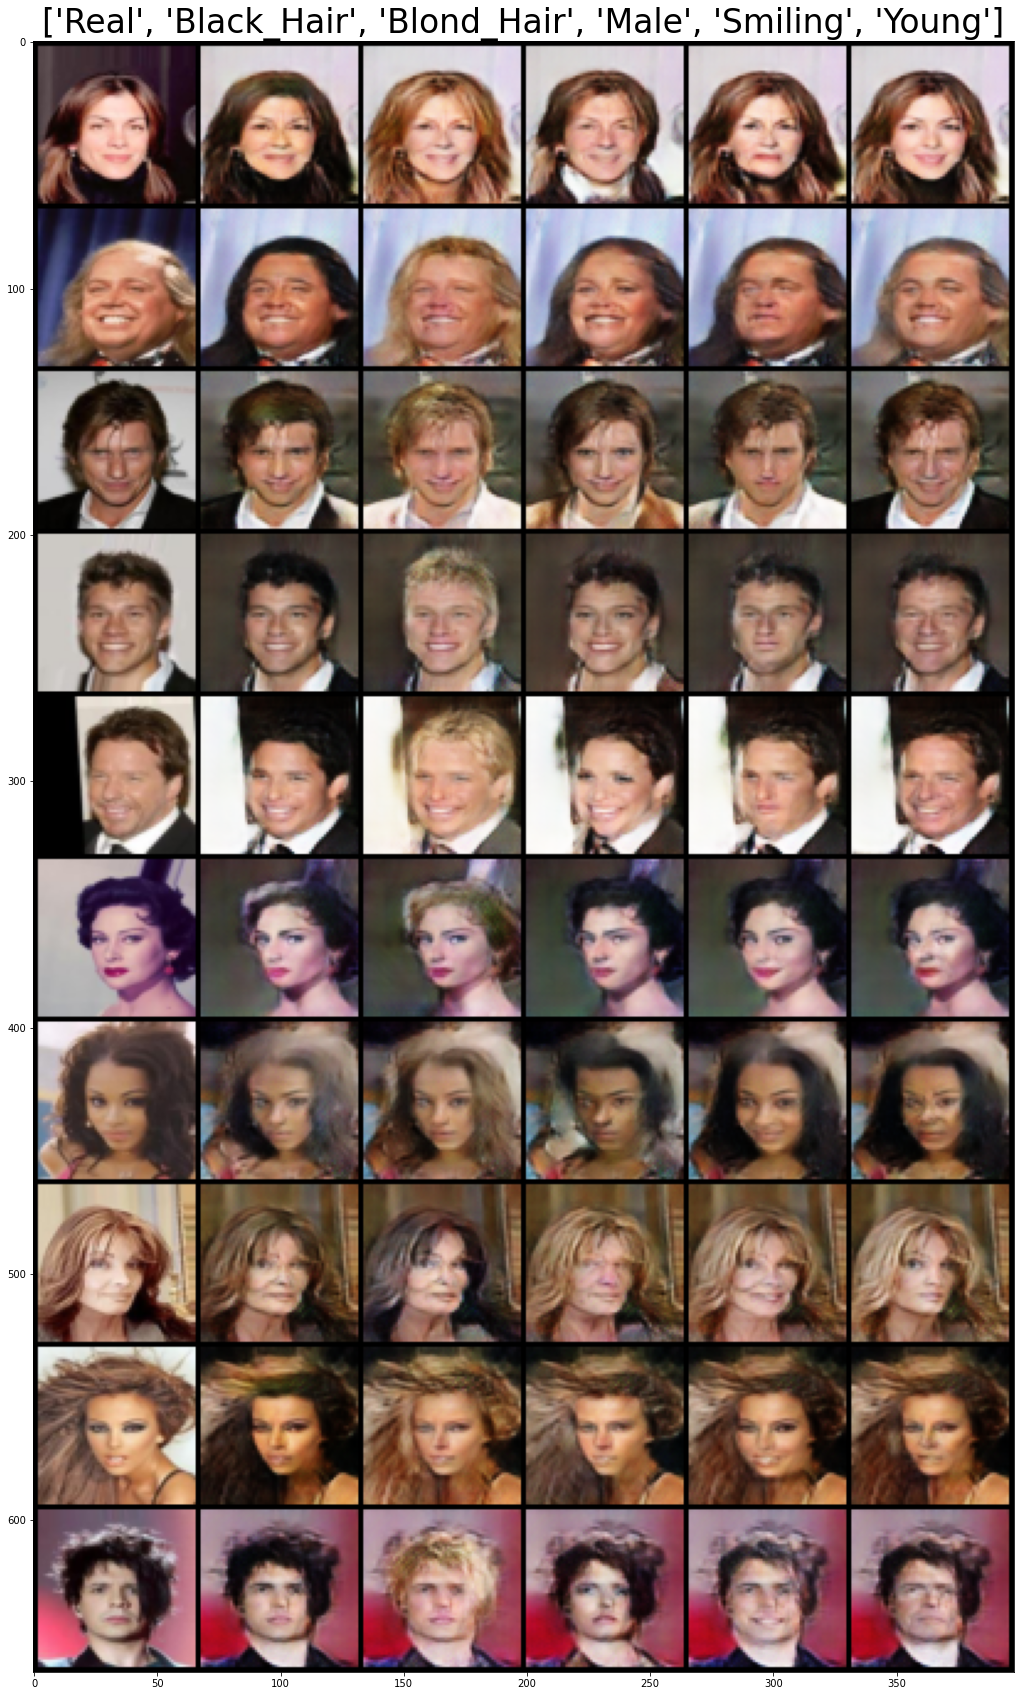

In [115]:
# data_iter = iter(test_dataloader)
batch = next(data_iter)
images, labels = batch[0][:10].to(device), batch[1][:10].to(device)

model.eval()
pictures = []
for i, (image, label) in enumerate(zip(images, labels)):
    label = label[attr]
    eye = torch.eye(label.shape[0]).to(device)
    label_trg = torch.abs(label - eye)[test_attr]
    image = image.unsqueeze(0).repeat(len(test_attr), 1, 1, 1)
    fake_image = model.generate(image.squeeze().to(device), label_trg.squeeze().to(device)).detach()
    image = ((image + 1) / 2).cpu()
    fake_image = ((fake_image + 1) / 2).cpu()
    pictures.append(torch.cat([image[0].unsqueeze(0), fake_image]))
pictures = make_grid(torch.cat(pictures), nrow=6).permute(1, 2, 0)

plt.figure(figsize=(30, 30))
plt.imshow(pictures)
plt.title(['Real'] + [index2attr[a] for a in np.array(attr)[test_attr]], fontsize=33)
plt.show()


## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежить готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета